author: @SteveEckel

This little script tests damped Rabi flopping as calculated with the optical
Bloch equations for a three level system.

Notation used within:
```
      ---- |e>



            ---- |r>
  ---- |g>

```

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.rateeq
import pylcp.obe
import time
from scipy.integrate import solve_ivp
plt.style.use('paper')

### Defining the problem.

We'll put the detuning into the Hamiltonian rather than the laser beams.

In [10]:
# First, define the lasers (functionalized for later):
Ige = 4; Ire = 4; Delta = -2; delta = 0.
def return_three_level_lasers(Ige, Ire):
    laserBeams = {}
    laserBeams['g->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ige}],
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    laserBeams['r->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ire}],                           
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    return laserBeams

laserBeams = return_three_level_lasers(Ige, Ire)

# Second, magnetic field:
magField = lambda R: np.zeros(R.shape)

# Now define the Hamiltonian (functionaized for later):
H0 = np.array([[1.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0,] = 1/np.sqrt(2)

def return_three_level_hamiltonian(Delta, delta):
    hamiltonian = pylcp.hamiltonian()
    hamiltonian.add_H_0_block('g', 0.*H0)
    hamiltonian.add_H_0_block('r', delta*H0)
    hamiltonian.add_H_0_block('e', Delta*H0)
    hamiltonian.add_d_q_block('g','e', d_q)
    hamiltonian.add_d_q_block('r','e', d_q)

    return hamiltonian

hamiltonian = return_three_level_hamiltonian(Delta, delta)
hamiltonian.print_structure()

[[(<g|H_0|g> 1x1) None (<g|d_q|e> 1x1)]
 [None (<r|H_0|r> 1x1) (<r|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) (<e|d_q|r> 1x1) (<e|H_0|e> 1x1)]]


### Set up the OBE

We'll first set up some damped Rabi oscillations in the three-level system.

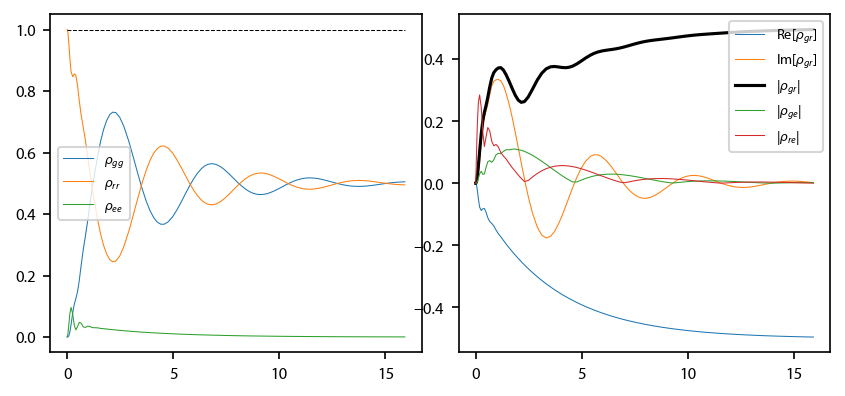

In [11]:
obe = pylcp.obe(laserBeams, magField, hamiltonian,
                transform_into_re_im=True)
obe.set_initial_rho_from_populations(np.array([0., 1., 0.]))
obe.evolve_density([0, 100])

fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 0]), linewidth=0.5, label='$\\rho_{gg}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[1, 1]), linewidth=0.5, label='$\\rho_{rr}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[2, 2]), linewidth=0.5, label='$\\rho_{ee}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 0]+obe.sol.rho[1, 1]+obe.sol.rho[2, 2]), 'k--', linewidth=0.5)
ax[0].legend(fontsize=7)

ax[1].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 1]), linewidth=0.5,
           label='Re$[\\rho_{gr}]$')
ax[1].plot(obe.sol.t/2/np.pi, np.imag(obe.sol.rho[0, 1]), linewidth=0.5,
           label='Im$[\\rho_{gr}]$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 1]), 'k-',
           label='$|\\rho_{gr}|$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 2]), linewidth=0.5, label='$|\\rho_{ge}|$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[1, 2]), linewidth=0.5, label='$|\\rho_{re}|$')
ax[1].legend(fontsize=7)

### Another fun three level problem is to look at the susceptibility and see some EIT

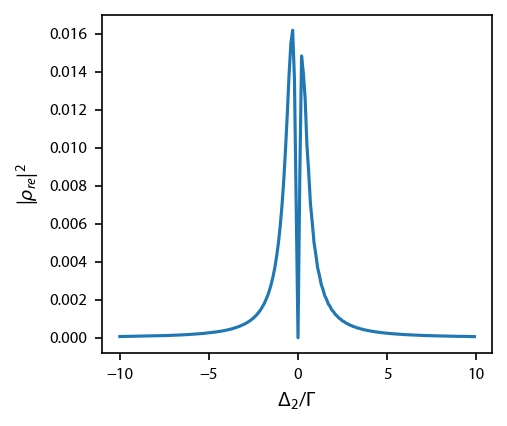

In [22]:
Delta = -0.1
deltas = np.arange(-10., 10., 0.1)
delta_random = np.random.choice(deltas)

include_random_sol = False

it = np.nditer([deltas, None])

if include_random_sol:
    fig, ax = plt.subplots(3, 1, figsize=(3.75, 2.5*3))
else:
    fig, ax = plt.subplots(1, 1)
    ax = [ax]
    
laserBeams = return_three_level_lasers(1, 0.1)
for delta, rhore in it:
    hamiltonian = return_three_level_hamiltonian(Delta, delta)
    obe = pylcp.obe(laserBeams, magField, hamiltonian,
                        transform_into_re_im=True)
    obe.set_initial_rho_from_populations([0, 1, 0])
    obe.evolve_density([0, 2*np.pi*5])

    if include_random_sol and np.abs(delta - delta_random)<1e-9:
        ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 0]),
                   linewidth=0.5, label='$|\\rho_{gg}|$')
        ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[1, 1]),
                   linewidth=0.5, label='$|\\rho_{rr}|$')
        ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[2, 2]),
                   linewidth=0.5, label='$|\\rho_{ee}|$')
        ax[1].legend(fontsize=7)

        ax[2].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[1, 2]),
                   linewidth=0.5, label='$|\\rho_{ge}|$')
        ax[2].plot(obe.sol.t/2/np.pi, np.imag(obe.sol.rho[1, 2]),
                   linewidth=0.5, label='$|\\rho_{re}|$')
        ax[2].legend(fontsize=7)

    rhore[...] = np.abs(obe.sol.rho[1, 2, -1])


ax[0].plot(deltas, it.operands[1]**2)
ax[0].set_ylabel('$|\\rho_{re}|^2$')
ax[0].set_xlabel('$\Delta_2/\Gamma$')

if include_random_sol:
    ax[0].plot([delta_random, delta_random], [0, np.amax(it.operands[1])**2], 'k-')
    ax[2].set_xlabel('$\Gamma t/(2\pi)$')
    fig.subplots_adjust(hspace=0.25)

In [23]:
fig.savefig('eit_susceptibility.pdf')

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


TODO: Another fun problem is STIRAP

One can of course, solve the three level problem it a silly way.  Let's consider
that r and g are seperated by a reasonably close amount, say 40 linewidths.
Then we can use a single rotating frame to solve the problem.  But buyer beware:
one should be careful about the minimum step size, because there are many things
oscillating in this Hamiltonian.  The results of this section should be compared
to the first figure in the script.

```
# %% Define the problem to start:
Delta_gf = 20. # Splitting between ground state levls g and f.

def return_three_level_lasers(Delta, delta, Ige, Ire, use_delta=True):
    if use_delta:
        laserBeams = pylcp.laserBeams([{'kvec':np.array([0., 0., 1.]),
                                        'pol':np.array([1., 0., 0.]),
                                        'pol_coord':'spherical',
                                        'delta':Delta_gf + Delta + delta/2,
                                        'beta':Ige},
                                       {'kvec':np.array([0., 0., 1.]),
                                        'pol':np.array([0., 0., 1.]),
                                        'pol_coord':'spherical',
                                        'delta':-Delta_gf + Delta - delta/2,
                                        'beta':Ire}])
    else:
        laserBeams = pylcp.laserBeams([{'kvec':np.array([0., 0., 1.]),
                                        'pol':np.array([1., 0., 0.]),
                                        'pol_coord':'spherical',
                                        'delta':Delta_gf + Delta,
                                        'beta':Ige},
                                       {'kvec':np.array([0., 0., 1.]),
                                        'pol':np.array([1., 0., 0.]),
                                        'pol_coord':'spherical',
                                        'delta':Delta_gf + delta,
                                        'beta':Ige}])
    return laserBeams

magField = lambda R: np.zeros(R.shape)

# Now define the extremely simple Hamiltonian:
Hg = np.array([[-Delta_gf, 0.], [0., Delta_gf]])
Bqg = np.zeros((3, 2, 2))
He = np.array([[0.]])
Bqe = np.array([[[0.]], [[0.]], [[0.]]])
dijq = np.zeros((3, 2, 1))
dijq[0] = np.array([[1/np.sqrt(2)], [0]])
dijq[2] = np.array([[0], [1/np.sqrt(2)]])
hamiltonian = pylcp.hamiltonian(Hg, He, Bqg, Bqe, dijq)

laserBeams = return_three_level_lasers(Delta, delta, Ige, Ire)
obe = pylcp.obe.obe(laserBeams, magField, hamiltonian,
                    transform_into_re_im=True, mean_detuning=0.)
rho0 = np.zeros((hamiltonian.n**2,), dtype='complex128')
rho0[obe.density_index(1, 1)] = 1.
obe.set_initial_rho(rho0)
#obe.set_initial_rho_from_rateeq()
tic = time.time()
obe.evolve_density(t_span=[0, 100], build_full_matrix=False,
                   max_step=1/Delta_gf/10, method='RK45')
print(time.time() - tic)

(t, rho) = obe.reshape_sol()

Eq = np.array([laserBeams.total_electric_field(t_i, obe.r0) for t_i in t])

fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ax[0].plot(t/2/np.pi, np.real(rho[0, 0]), linewidth=0.5, label='$\\rho_{gg}$')
ax[0].plot(t/2/np.pi, np.real(rho[1, 1]), linewidth=0.5, label='$\\rho_{rr}$')
ax[0].plot(t/2/np.pi, np.real(rho[2, 2]), linewidth=0.5, label='$\\rho_{ee}$')
ax[0].plot(t/2/np.pi, np.real(rho[0, 0]+rho[1, 1]+rho[2, 2]), 'k--', linewidth=0.5)
ax[0].legend(fontsize=7)

ax[1].plot(t/2/np.pi, np.real(rho[0, 1]), linewidth=0.5,
           label='Re$[\\rho_{gr}]$')
ax[1].plot(t/2/np.pi, np.imag(rho[0, 1]), linewidth=0.5,
           label='Im$[\\rho_{gr}]$')
ax[1].plot(t/2/np.pi, np.abs(rho[0, 1]), 'k-',
           label='$|\\rho_{gr}|$')
ax[1].plot(t/2/np.pi, np.abs(rho[0, 2]), linewidth=0.5, label='$|\\rho_{ge}|$')
ax[1].plot(t/2/np.pi, np.abs(rho[1, 2]), linewidth=0.5, label='$|\\rho_{re}|$')
ax[1].legend(fontsize=7)
#fig.savefig('damped_rabi_flopping_take_4.pdf')
```